In [1]:
import pandas as pd
import numpy as np
import bilby
import lal
import gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import copy

import sys
sys.path.append("..")

from waveforms import osc_freq_XPHM, mem_freq_XPHM, mem_freq_XPHM_only
from create_post_dict import create_post_dict, extract_relevant_info

In [2]:
logger = bilby.core.utils.logger

def call_data_GWOSC(logger, args, calibration, samples, detectors, start_time, end_time, psd_start_time, psd_end_time, duration, sampling_frequency, roll_off, minimum_frequency, maximum_frequency, psds_array=None, plot=False):
    
    ifo_list = bilby.gw.detector.InterferometerList([])
    
    # define interferometer objects
    for det in detectors:   
        logger.info("Downloading analysis data for ifo {}".format(det))
        ifo = bilby.gw.detector.get_empty_interferometer(det)
        ifo.strain_data.roll_off = roll_off
        
        channel_type = args['channel_dict'][det]
        channel = f"{det}:{channel_type}"
        
        kwargs = dict(
            start=start_time,
            end=end_time,
            verbose=False,
            allow_tape=True,
        )

        type_kwargs = dict(
            dtype="float64",
            subok=True,
            copy=False,
        )
        data = gwpy.timeseries.TimeSeries.get(channel, **kwargs).astype(
                **type_kwargs)
        
        # Resampling timeseries to sampling_frequency using lal.
        lal_timeseries = data.to_lal()
        lal.ResampleREAL8TimeSeries(
            lal_timeseries, float(1/sampling_frequency)
        )
        data = TimeSeries(
            lal_timeseries.data.data,
            epoch=lal_timeseries.epoch,
            dt=lal_timeseries.deltaT
        )
    
        # define some attributes in ifo
        ifo.maximum_frequency = maximum_frequency
        ifo.minimum_frequency = minimum_frequency
        
        # set data as the strain data
        ifo.strain_data.set_from_gwpy_timeseries(data)
        
        # compute the psd
        if det in psds_array.keys():
            print("Using pre-computed psd from results file")
            print(psds_array)
            ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=psds_array[det][: ,0], psd_array=psds_array[det][:, 1]
            )
        else:
            print('Error: PSD is missing!')
            exit()

        ifo_list.append(ifo)

    return ifo_list, data

In [3]:
events_name = 'GW170818' 
file_path = '/home/shunyin.cheung/GWOSC_posteriors/IGWN-GWTC2p1-v2-GW170818_022509_PEDataRelease_mixed_cosmo.h5'
waveform = "C01:IMRPhenomXPHM"
data_file = None

samples, meta_dict, config_dict, priors, psds, calibration = create_post_dict(file_path, waveform)
args = extract_relevant_info(meta_dict, config_dict)

logger = bilby.core.utils.logger

sampling_frequency = args['sampling_frequency']
maximum_frequency = args['maximum_frequency']
minimum_frequency = args['minimum_frequency']
reference_frequency = args['reference_frequency']
roll_off = args['tukey_roll_off']
duration = args['duration']
post_trigger_duration = args['post_trigger_duration']
trigger_time = args['trigger_time']
detectors = args['detectors']

detectors = args['detectors']
if 'V1' in detectors:
    detectors.remove('V1')

end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

psd_duration = 32*duration # deprecated
psd_start_time = start_time - psd_duration # deprecated
psd_end_time = start_time # deprecated


waveform_name = args['waveform_approximant']

print(minimum_frequency)
print(trigger_time)


Jitter time setting cannot be found. Use default setting.
channel_dict {'H1': 'DCH-CLEAN_STRAIN_C02', 'L1': 'DCH-CLEAN_STRAIN_C02', 'V1': 'Hrec_hoft_V1O2Repro2A_16384Hz'}
['', 'home', 'daniel.williams', 'events', 'O3', 'o3a_final', 'run_directories', '', 'GW170818', 'ProdF7']
20.0
1187058327.081509


In [4]:
ifo_list, data = call_data_GWOSC(logger, args, 
                            calibration, samples, detectors,
                            start_time, end_time, 
                            psd_start_time, psd_end_time, 
                            duration, sampling_frequency, 
                            roll_off, minimum_frequency, maximum_frequency,
                            psds_array=psds)

18:15 bilby INFO    : Downloading analysis data for ifo L1
18:15 bilby INFO    : Downloading analysis data for ifo H1


Using pre-computed psd from results file
{'H1': array([[0.00000e+00, 5.00000e-01],
       [2.50000e-01, 5.00000e-01],
       [5.00000e-01, 5.00000e-01],
       ...,
       [1.02325e+03, 1.13815e-46],
       [1.02350e+03, 1.12502e-46],
       [1.02375e+03, 1.99526e-44]]), 'L1': array([[0.00000e+00, 5.00000e-01],
       [2.50000e-01, 5.00000e-01],
       [5.00000e-01, 5.00000e-01],
       ...,
       [1.02325e+03, 2.16067e-46],
       [1.02350e+03, 2.21825e-46],
       [1.02375e+03, 4.20475e-46]]), 'V1': array([[0.00000e+00, 5.00000e-01],
       [2.50000e-01, 5.00000e-01],
       [5.00000e-01, 5.00000e-01],
       ...,
       [1.02325e+03, 8.75114e-46],
       [1.02350e+03, 8.68830e-46],
       [1.02375e+03, 9.46978e-46]])}
Using pre-computed psd from results file
{'H1': array([[0.00000e+00, 5.00000e-01],
       [2.50000e-01, 5.00000e-01],
       [5.00000e-01, 5.00000e-01],
       ...,
       [1.02325e+03, 1.13815e-46],
       [1.02350e+03, 1.12502e-46],
       [1.02375e+03, 1.99526e-44]

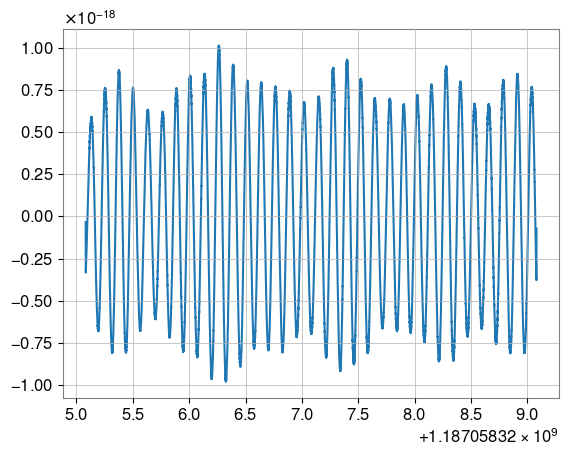

In [40]:
plt.plot(data.times, ifo_list[1].strain_data.time_domain_strain)
plt.show()

In [6]:
ifo_list[1].plot_time_domain_data(outdir='tests', label='td_data_GW170818')
ifo_list[0].plot_time_domain_data(outdir='tests', label='td_data_GW170818')


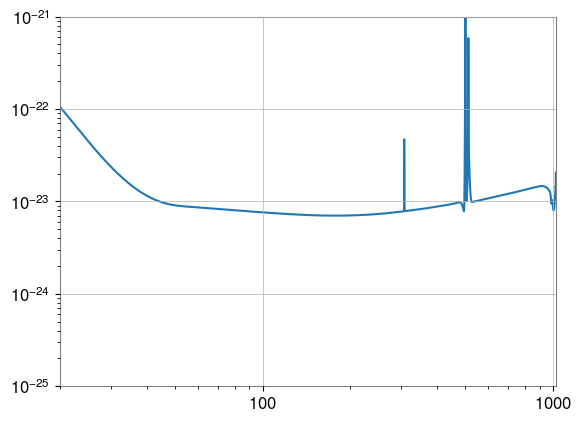

In [7]:
strain = ifo_list[0].amplitude_spectral_density_array
freq = ifo_list[0].frequency_array
plt.loglog(freq, strain)
plt.xlim(20, 1024)
plt.ylim(1e-25, 1e-21)
plt.show()

In [6]:
amplitude = 1
print('amplitude = ',amplitude)

priors2 = copy.copy(priors)

# test if bilby oscillatory waveform = gwmemory oscillatory waveform.
waveform_generator_osc = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= bilby.gw.source.lal_binary_black_hole,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            waveform_approximant=waveform_name,
                            )

)

# define oscillatory + memory model using gwmemory.
waveform_generator_full = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

waveform_generator_mem = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM_only,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

target_likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifo_list,
    waveform_generator_osc,
    time_marginalization = True,
    distance_marginalization = True,
    distance_marginalization_lookup_table = '../TD.npz',
    jitter_time=True,
    priors = priors2,
    reference_frame = args['reference_frame'],
    time_reference = args['time_reference'],
)

18:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
18:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_v2
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
18:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_only
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


amplitude =  1


18:15 bilby INFO    : Loaded distance marginalisation lookup table from ../TD.npz.


In [7]:
# mean_parameters = dict()
# for key in samples:
#     value = np.mean(samples[key])
#     mean_parameters[key] = value
#     #print(key, value)
# posterior = mean_parameters

max_like = np.argmax(samples['log_likelihood'])
posterior = samples.iloc[max_like].to_dict()

In [8]:
for key in posterior:
    print(key, posterior[key])

chirp_mass 32.47169638467574
mass_ratio 0.5825169368741304
a_1 0.9762738743394399
a_2 0.7041313542735808
tilt_1 1.5747020977010517
tilt_2 2.163585393672113
phi_12 0.03972505087514857
phi_jl 4.72421709126025
theta_jn 2.575635255160377
psi 2.140299676813574
phase 5.933424565575547
azimuth 6.272206563786908
zenith 2.222155265115197
recalib_H1_amplitude_0 0.009161248722510763
recalib_H1_amplitude_1 0.0057298865357775005
recalib_H1_amplitude_2 0.015960142486124
recalib_H1_amplitude_3 -7.882934787776825e-06
recalib_H1_amplitude_4 -0.00250153214508948
recalib_H1_amplitude_5 -0.02368682236374731
recalib_H1_amplitude_6 -0.0011819251830658926
recalib_H1_amplitude_7 0.006098387792439327
recalib_H1_amplitude_8 0.001799996886113596
recalib_H1_amplitude_9 0.007475140402744737
recalib_H1_phase_0 -0.010452859768175934
recalib_H1_phase_1 -0.0017709455661273437
recalib_H1_phase_2 -0.004023643239071487
recalib_H1_phase_3 -0.011560605347905114
recalib_H1_phase_4 0.028016458393936166
recalib_H1_phase_5 -0.

In [9]:
frequency_domain_strain = waveform_generator_full.frequency_domain_strain(posterior)
time_domain_strain_osc = waveform_generator_osc.time_domain_strain(posterior)
time_domain_strain_full = waveform_generator_full.time_domain_strain(posterior)
time_domain_strain_mem = waveform_generator_mem.time_domain_strain(posterior)

time_array = waveform_generator_full.time_array
target_likelihood.parameters.update(posterior)
snr_array_H1 = target_likelihood.calculate_snrs(frequency_domain_strain, ifo_list[1])
opt_snr_H = snr_array_H1.optimal_snr_squared
cmf_snr_H = snr_array_H1.complex_matched_filter_snr
snr_array_L1 = target_likelihood.calculate_snrs(frequency_domain_strain, ifo_list[0])
opt_snr_L = snr_array_L1.optimal_snr_squared
cmf_snr_L = snr_array_L1.complex_matched_filter_snr
print('full waveform')
print('network opt SNR: ', np.sqrt(opt_snr_H+opt_snr_L))
# print('network complex matched_filter SNR', cmf_snr_H + cmf_snr_L)
print('stored network opt SNR', np.sqrt(posterior['H1_optimal_snr']**2+posterior['L1_optimal_snr']**2))
print('H1 snr', opt_snr_H)

full waveform
network opt SNR:  10.216751833544258
stored network opt SNR 10.342348771734432
H1 snr 22.277106721177244


In [10]:
print('H1 snr', np.sqrt(opt_snr_H))
print('L1 snr', np.sqrt(opt_snr_L))
print('stored H1 opt snr', posterior['H1_optimal_snr'])
print('stored L1 opt snr', posterior['L1_optimal_snr'])

H1 snr 4.719862998136413
L1 snr 9.061176044369335
stored H1 opt snr 4.680081226675691
stored L1 opt snr 9.222853019967005


In [11]:
frequency_domain_strain_mem = waveform_generator_mem.frequency_domain_strain(posterior)
snr_array_H1 = target_likelihood.calculate_snrs(frequency_domain_strain_mem, ifo_list[0])
opt_snr_H = snr_array_H1.optimal_snr_squared
cmf_snr_H = snr_array_H1.complex_matched_filter_snr
snr_array_L1 = target_likelihood.calculate_snrs(frequency_domain_strain_mem, ifo_list[1])
opt_snr_L = snr_array_L1.optimal_snr_squared
cmf_snr_L = snr_array_L1.complex_matched_filter_snr

print('memory-only waveform')
print('network opt SNR: ', np.sqrt(opt_snr_H+opt_snr_L))
print('network complex matched_filter SNR', cmf_snr_H+cmf_snr_L)

memory-only waveform
network opt SNR:  0.026821972902571215
network complex matched_filter SNR (3.8109313577676023+2.0487724621860113j)


In [12]:
td_plus_osc = time_domain_strain_osc['plus']
td_cross_osc = time_domain_strain_osc['cross']

plt.figure()
#plt.plot(time_array, np.roll(time_domain_strain_full['plus']-1j*time_domain_strain_full['cross'], -4096), linestyle='dashed', label='full')
#plt.plot(strain.times, np.roll(np.flip(strain.value),-4096), label='H1', alpha=0.6)
plt.plot(time_array, np.roll(td_plus_osc-1j*td_cross_osc, -4096), label='osc only')
#plt.plot(time_array, np.roll(time_domain_strain_mem['plus']-1j*time_domain_strain_mem['cross'], -4096), label='mem only')
#plt.plot(time_array, np.roll(time_domain_strain_osc2['plus']-1j*time_domain_strain_osc2['cross'], -4096), label='m1=8, m2=8')
plt.legend()
plt.xlim(trigger_time-0.5, trigger_time+0.5)
plt.savefig(f'test_results/td_waveform_{amplitude}_{events_name}.png')
plt.show()

# plt.figure()
# plt.plot(strain.times)

/home/shunyin.cheung/.conda/envs/altenv/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


FileNotFoundError: [Errno 2] No such file or directory: 'tests/td_waveform_1_GW170818.png'

[0.00000e+00 2.50000e-01 5.00000e-01 ... 1.02350e+03 1.02375e+03
 1.02400e+03]


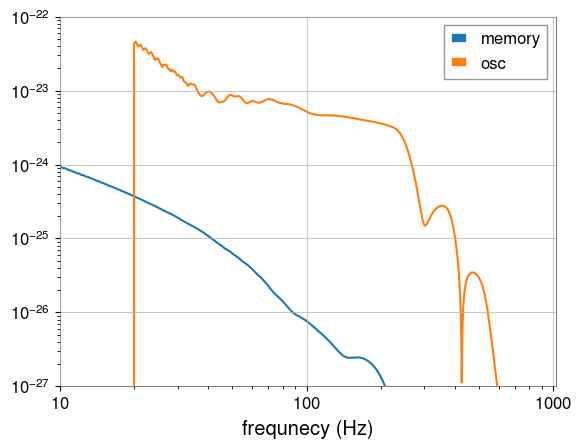

In [69]:
frequency_array = waveform_generator_mem.frequency_array
fd_strain_osc = waveform_generator_osc.frequency_domain_strain(posterior)
print(frequency_array)
plt.figure()
plt.loglog(frequency_array, np.abs(frequency_domain_strain_mem['plus']+frequency_domain_strain_mem['cross']), label='memory')
plt.loglog(frequency_array, np.abs(fd_strain_osc['plus']+fd_strain_osc['cross']), label='osc')
plt.xlabel('frequnecy (Hz)')
plt.ylim(1e-27, 1e-22)
plt.xlim(10, 1024)
plt.legend()
plt.show()

In [115]:
recons_fd, recons_freq = bilby.core.utils.nfft(strain.value, sampling_frequency)

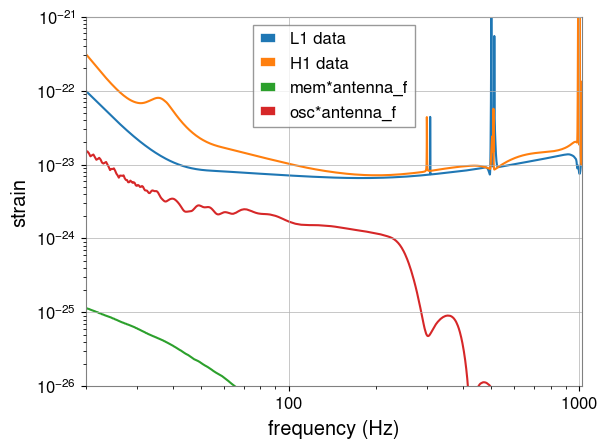

In [157]:
strain_H1 = ifo_list[1].amplitude_spectral_density_array
strain_L1 = ifo_list[0].amplitude_spectral_density_array

fd_osc_L1 = ifo_list[1].get_detector_response(fd_strain_osc, posterior)
fd_mem_L1 = ifo_list[1].get_detector_response(frequency_domain_strain_mem, posterior)

freq = ifo_list[0].frequency_array
plt.loglog(freq, strain_L1, label='L1 data')
plt.loglog(freq, strain_H1, label='H1 data')
#plt.loglog(recons_freq, np.abs(recons_fd), label='td nfft')
#plt.loglog(freq, np.abs(frequency_domain_strain_mem['plus']+frequency_domain_strain_mem['cross']), label='memory')
plt.loglog(freq, np.abs(fd_mem_L1), label='mem*antenna_f')
#plt.loglog(freq, np.abs(fd_strain_osc['plus']+fd_strain_osc['cross']), label='osc')
plt.loglog(freq, np.abs(fd_osc_L1), label='osc*antenna_f')
plt.xlim(20, 1024)
plt.ylim(1e-26, 1e-21)
plt.xlabel('frequency (Hz)')
plt.ylabel('strain')
plt.legend()
plt.show()

In [13]:
reference_parameters = dict(luminosity_distance = priors2['luminosity_distance'], 
                            geocent_time = priors2['geocent_time'])
target_likelihood.parameters.update(posterior)
target_likelihood.parameters.update(reference_parameters)
print(target_likelihood.log_likelihood_ratio())
print(posterior['log_likelihood'])

54.647662653550896
64.84156626417015


In [9]:
print(samples['log_likelihood'].mean())

59.32835540897537


In [16]:
for i in range(10):
    posterior = samples.iloc[i].to_dict()
    target_likelihood.parameters.update(posterior)
    reference_parameters = dict(luminosity_distance = priors2['luminosity_distance'],
                                geocent_time = priors2['geocent_time'])
    target_likelihood.parameters.update(reference_parameters)
    likelihood = target_likelihood.log_likelihood_ratio()
    print(samples['log_likelihood'].iloc[i],likelihood)

61.49206647861965 51.66951311123018
61.10075751046299 50.818156072200836
59.12672625501739 51.75056994749835
55.96990766273144 47.115619363131046
59.577235624802576 50.29536930790279
57.569143395324296 48.618799553349916
60.33188150841454 50.724406029389485
61.742284236457905 52.354260116113196
57.75200697712786 48.36696375689809
60.347512814011296 51.55224511701354
